In [1]:
from __future__ import print_function, division
#Allows relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports from files
from src.preprocessing import *
from src.VAE_train import *
from src.vautoencoders import *
from src.loss_metrics import *
from src.pickling import *
from src.datasets import *

import pandas as pd 
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))
    
#Plot and stuff
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
sns.set_style('darkgrid')


# Ignore warnings)
import warnings
warnings.filterwarnings("ignore")
    
%load_ext autoreload
%autoreload 2

Using : cuda


In [2]:
emerson = pd.read_csv('../training_data_new/emerson_raw/batch1/emerson_batch1_626hla_parsed_tagged.tsv', sep='\t')
sample_tags = pd.read_csv('../training_data_new/emerson_raw/batch1/emerson_batch1_sampletags.tsv', sep ='\t')

In [2]:
### Normal AE without positional Encoding (best model) ###
model_reload =  AutoEncoder(latent_dim = 40, aa_dim = 21, 
                             seq_len = 23, act = nn.SELU())
chkpt = torch.load('./Best_AE_model_latdim40_withSELU.pth.tar')
model_reload.load_state_dict(chkpt['state_dict'])
##########################################################

<All keys matched successfully>

### Getting the freq Matrix

In [184]:
#Checking the count
count = pd.DataFrame(index=emerson.v_family.unique(), columns = ['top10_freq', 'top5_freq',
                                                                 'top10_count','top5_count'], dtype=int).sort_index()
count[count.columns] = 0

for fn in sample_tags.filename.values:
    sub = emerson.query('filename==@fn')[['frequency', 'v_family','v_number']]
    sub = sub.groupby('v_family')\
             .agg(sum_freq= ('frequency','sum'),
                  count = ('frequency','count'))
    sub['normed_freq'] = sub.apply(lambda x : x['sum_freq']/sub['sum_freq'].sum(), axis=1)
    sub['normed_count'] = sub.apply(lambda x : x['count']/sub['count'].sum(), axis = 1)
    s1 = sub.sort_values('sum_freq', ascending=False)
    s2 = sub.sort_values('count', ascending = False)
    count.loc[s1.head(10).index.values,'top10_freq'] += 1
    count.loc[s1.head(5).index.values,'top5_freq'] += 1
    count.loc[s2.head(10).index.values,'top10_count'] += 1
    count.loc[s2.head(5).index.values,'top5_count'] += 1
count.sort_values('top10_count',ascending=False)

,top10_freq,top5_freq,top10_count,top5_count
TCRBV05,626.0,623.0,626.0,624.0
TCRBV06,626.0,626.0,626.0,626.0
TCRBV07,626.0,619.0,626.0,623.0
TCRBV04,624.0,534.0,625.0,528.0
TCRBV19,602.0,251.0,612.0,323.0
TCRBV02,615.0,193.0,607.0,196.0
TCRBV10,583.0,67.0,554.0,23.0
TCRBV28,495.0,126.0,492.0,127.0
TCRBV27,411.0,11.0,372.0,7.0
TCRBV11,326.0,28.0,344.0,23.0


In [243]:
from tqdm.auto import tqdm
unique_v = pd.Index(sorted(emerson.v_family.unique()))
cols = pd.Index(['filename','hla_a1','hla_a2','hla_b1','hla_b2']).append(unique_v)

sumFREQ = pd.DataFrame(columns = cols)
occurenceFREQ = pd.DataFrame(columns = cols)
normed_sumFREQ = pd.DataFrame(columns = cols)

for fn in tqdm(sample_tags.filename.values):
    infos = sample_tags.query('filename == @fn')[['filename','hla_a1','hla_a2','hla_b1','hla_b2']]
    infos = infos.reset_index(drop=True)
    
    sub = emerson.query('filename==@fn')[['frequency', 'v_family','v_number']]
    sub = sub.groupby('v_family')\
             .agg(sum_freq= ('frequency','sum'),
                  count = ('frequency','count'))
    sub['normed_count'] = sub.apply(lambda x : x['count']/sub['count'].sum(), axis = 1)
    sub['normed_freq'] = sub.apply(lambda x : x['sum_freq']/sub['sum_freq'].sum(), axis = 1)
    idx = sub.index #Here to get the difference
    diff = unique_v.difference(sub.index)
    #Fill the difference with zeros since it's not in the repertoire
    sub = sub.append(pd.DataFrame(data = 0, columns = sub.columns,
                                  index = diff), 
                     ignore_index = False)
    # Here 0 for sumFreq which is the sum of the real frequency
    # 2 for normed_count which is the occurence frequency
    sub_freq = sub.sort_index().T.reset_index(drop=True).loc[[0]] 
    sub_freq = pd.concat([infos, sub_freq], axis = 1)
    sumFREQ = sumFREQ.append(sub_freq, ignore_index = True)
    
    # Normalized count (occurences) i.e. frequency of occurence
    sub_count = sub.sort_index().T.reset_index(drop=True).loc[[2]].reset_index(drop=True)
    sub_count = pd.concat([infos, sub_count], axis = 1)
    occurenceFREQ = occurenceFREQ.append(sub_count, ignore_index = True)
    
    #Normalized sum of frequencies for a given TCRBV family
    sub_freq = sub.sort_index().T.reset_index(drop=True).loc[[3]].reset_index(drop=True)
    sub_freq = pd.concat([infos, sub_freq], axis = 1)
    normed_sumFREQ = normed_sumFREQ.append(sub_freq, ignore_index = True)

  0%|          | 0/626 [00:00<?, ?it/s]

In [227]:
occurenceFREQ.to_csv('../training_data_new/emerson_raw/batch1/occurence_freq.csv', header=True, index = False)
sumFREQ.to_csv('../training_data_new/emerson_raw/batch1/sum_freq.csv', header=True, index = False)
normed_sumFREQ.to_csv('../training_data_new/emerson_raw/batch1/normed_sumfreq.csv', header=True, index = False)

### Corr computation
Below lies some of the worst code I've ever written

In [59]:
from sklearn.feature_selection import chi2, f_classif, f_regression
from scipy.stats import pearsonr, spearmanr, pointbiserialr

In [2]:
occurenceFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/occurence_freq.csv', header=0)
sumFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/sum_freq.csv', header=0)
normed_sumFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/normed_sumfreq.csv', header=0)

In [83]:
normed_sumFREQ

,filename,hla_a1,hla_a2,hla_b1,hla_b2,TCRBV01,TCRBV02,TCRBV04,TCRBV05,TCRBV06,...,TCRBV20,TCRBV21,TCRBV22,TCRBV23,TCRBV25,TCRBV26,TCRBV27,TCRBV28,TCRBV29,TCRBV30
0,HIP00110.tsv,A03,A24,B07,Unknown,0.000495,0.071885,0.046971,0.201917,0.206634,...,0.001468,0.005394,0.000000,0.001332,0.022139,0.0,0.035231,0.009275,0.025531,0.040030
1,HIP00169.tsv,A01,A02,B27,B37,0.000193,0.063454,0.080458,0.185111,0.191750,...,0.001509,0.003876,0.000000,0.000895,0.010400,0.0,0.030678,0.034171,0.023331,0.036941
2,HIP00594.tsv,A02,A32,B07,B61,0.000853,0.045658,0.088701,0.159756,0.147482,...,0.000336,0.003453,0.000000,0.000996,0.014907,0.0,0.092859,0.077912,0.013406,0.028181
3,HIP00602.tsv,A02,A11,B35,B51,0.000190,0.051062,0.134060,0.160352,0.148044,...,0.002721,0.017610,0.000053,0.001433,0.029529,0.0,0.021241,0.039764,0.019838,0.007920
4,HIP00614.tsv,A03,A29,B07,Unknown,0.000703,0.032676,0.077798,0.080069,0.304321,...,0.002015,0.000573,0.000000,0.001756,0.005617,0.0,0.067582,0.039761,0.015335,0.022250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,HIP17887.tsv,A02,A29,B07,B44,0.000415,0.057218,0.082326,0.189236,0.204389,...,0.004896,0.004140,0.000000,0.001085,0.024135,0.0,0.031537,0.058360,0.021264,0.030585
622,HIP19048.tsv,A01,A02,B51,B57,0.001196,0.108507,0.041735,0.201183,0.177715,...,0.002952,0.006633,0.000000,0.002341,0.016670,0.0,0.042318,0.043623,0.017195,0.014233
623,HIP19089.tsv,A01,A80,B13,B44,0.001152,0.055930,0.046931,0.140144,0.116707,...,0.003208,0.000521,0.000000,0.000874,0.004445,0.0,0.051737,0.070352,0.021011,0.038512
624,HIP19716.tsv,A01,Unknown,B08,Unknown,0.000317,0.055437,0.140832,0.133957,0.162500,...,0.003560,0.010729,0.000000,0.002419,0.023755,0.0,0.020972,0.041400,0.014277,0.020687


In [122]:
XMAT = (normed_sumFREQ[X_cols] >= 0.05) + 0
#normed_sumFREQ[X_cols] < 0.01 =
XMAT.sum(axis=0) #626 total patients

TCRBV01      0
TCRBV02    392
TCRBV04    596
TCRBV05    626
TCRBV06    626
TCRBV07    626
TCRBV08      0
TCRBV09     13
TCRBV10    159
TCRBV11    133
TCRBV12      1
TCRBV13      7
TCRBV14      7
TCRBV15      3
TCRBV16      0
TCRBV18      6
TCRBV19    458
TCRBV20      0
TCRBV21      2
TCRBV22      0
TCRBV23      0
TCRBV25     19
TCRBV26      0
TCRBV27     42
TCRBV28    260
TCRBV29     14
TCRBV30     19
dtype: int64

In [63]:
# Using normed_sumFREQ:
X_cols = normed_sumFREQ.columns[normed_sumFREQ.columns.str.startswith('TCRB')]
X = normed_sumFREQ[X_cols].values #shape (N, 27)

y_cols = ['hla_a1','hla_a2','hla_b1','hla_b2']
hla = normed_sumFREQ[y_cols].values
y_a, y_b = get_all_label(hla[:,0], hla[:,1], # y_a: shape (N, 21)
                         hla[:,2], hla[:,3]) # y_b: shape (N, 40)

In [123]:
#Correlations
from sklearn.feature_selection import chi2, f_classif, f_regression
from scipy.stats import pearsonr, spearmanr, pointbiserialr

pd.options.display.float_format = '{:.5f}'.format
for metric in [pearsonr]:#, spearmanr, pointbiserialr]:
    name = metric.__name__
    index_a = pd.MultiIndex.from_product([hla_a, [name, 'p_val']], names = ['HLA','value'])
    index_b = pd.MultiIndex.from_product([hla_b, [name, 'p_val']], names = ['HLA','value'])
    tmp_A = pd.DataFrame(index = index_a, columns = X_cols)
    tmp_B = pd.DataFrame(index = index_b, columns = X_cols)
    for TCRBV in tqdm(X_cols):
        for A in range(21):
            tmp_A.loc[hla_a[A], TCRBV]= metric(XMAT[TCRBV].values, y_a[:, A])
        for B in range(40):
            tmp_B.loc[hla_b[B], TCRBV]= metric(XMAT[TCRBV].values, y_b[:, B])
    tmp_A.to_csv(f'{name}_HLA_A_from_normed_sumFREQ.csv', index =True, header= True)
    tmp_B.to_csv(f'{name}_HLA_B_from_normed_sumFREQ.csv', index =True, header= True)
    
#Other tests statistics   
#for metric in [chi2, f_classif, f_regression, ]:
#    name = metric.__name__
#    index_a = pd.MultiIndex.from_product([hla_a, [name, 'p_val']], names = ['HLA','value'])
#    index_b = pd.MultiIndex.from_product([hla_b, [name, 'p_val']], names = ['HLA','value'])
#    tmp_A = pd.DataFrame(index = index_a, columns = X_cols)
#    tmp_B = pd.DataFrame(index = index_b, columns = X_cols)
#    for A in range(21):
#        tmp_A.loc[hla_a[A]] = metric(X, y_a[:,A])
#    for B in range(40):
#        tmp_B.loc[hla_b[B]] = metric(X, y_b[:,B])
#    tmp_A.to_csv(f'{name}_HLA_A_from_normed_sumFREQ.csv', index =True, header= True)
#    tmp_B.to_csv(f'{name}_HLA_B_from_normed_sumFREQ.csv', index =True, header= True)

  0%|          | 0/27 [00:00<?, ?it/s]

In [128]:
tmp_A

TCRBV01  TCRBV02  TCRBV04 TCRBV05 TCRBV06 TCRBV07 TCRBV08  \
HLA value                                                                
A01 pearsonr     NaN  0.07606 -0.00141     NaN     NaN     NaN     NaN   
    p_val        NaN  0.05718  0.97188     NaN     NaN     NaN     NaN   
A02 pearsonr     NaN -0.01391  0.04629     NaN     NaN     NaN     NaN   
    p_val        NaN  0.72837  0.24744     NaN     NaN     NaN     NaN   
A03 pearsonr     NaN -0.02926 -0.08123     NaN     NaN     NaN     NaN   
    p_val        NaN  0.46491  0.04219     NaN     NaN     NaN     NaN   
A11 pearsonr     NaN -0.02447 -0.00193     NaN     NaN     NaN     NaN   
    p_val        NaN  0.54109  0.96149     NaN     NaN     NaN     NaN   
A23 pearsonr     NaN  0.03401 -0.02599     NaN     NaN     NaN     NaN   
    p_val        NaN   0.3956  0.51625     NaN     NaN     NaN     NaN   
A24 pearsonr     NaN -0.01453  0.04035     NaN     NaN     NaN     NaN   
    p_val        NaN  0.71679  0.31353     NaN     NaN     NaN     NaN   
A25 pearsonr     NaN  0.02844   0.0467     NaN     NaN     NaN     NaN   
    p_val        NaN  0.47745  0.24328     NaN     NaN     NaN     NaN   
A26 pearsonr     NaN   0.0084   0.0661     NaN     NaN     NaN     NaN   
    p_val        NaN  0.83376  0.09846     NaN     NaN     NaN     NaN   
A28 pearsonr     NaN -0.07328   0.0127     NaN     NaN     NaN     NaN   
    p_val        NaN  0.06693  0.75111     NaN     NaN     NaN     NaN   
A29 pearsonr     NaN -0.05249 -0.01666     NaN     NaN     NaN     NaN   
    p_val        NaN  0.18964  0.67743     NaN     NaN     NaN     NaN   
A30 pearsonr     NaN  0.01557  0.02205     NaN     NaN     NaN     NaN   
    p_val        NaN  0.69751  0.58192     NaN     NaN     NaN     NaN   
A31 pearsonr     NaN  0.01973 -0.04747     NaN     NaN     NaN     NaN   
    p_val        NaN  0.62219   0.2356     NaN     NaN     NaN     NaN   
A32 pearsonr     NaN -0.04674  0.02689     NaN     NaN     NaN     NaN   
    p_val        NaN  0.24288  0.50189     NaN     NaN     NaN     NaN   
A33 pearsonr     NaN  0.03987  0.00221     NaN     NaN     NaN     NaN   
    p_val        NaN  0.31926  0.95608     NaN     NaN     NaN     NaN   
A34 pearsonr     NaN -0.07484  0.02386     NaN     NaN     NaN     NaN   
    p_val        NaN   0.0613  0.55129     NaN     NaN     NaN     NaN   
A36 pearsonr     NaN   0.0309 -0.17829     NaN     NaN     NaN     NaN   
    p_val        NaN  0.44019  0.00001     NaN     NaN     NaN     NaN   
A66 pearsonr     NaN -0.06236 -0.07587     NaN     NaN     NaN     NaN   
    p_val        NaN  0.11911  0.05782     NaN     NaN     NaN     NaN   
A68 pearsonr     NaN  0.03218 -0.07798     NaN     NaN     NaN     NaN   
    p_val        NaN  0.42148  0.05118     NaN     NaN     NaN     NaN   
A69 pearsonr     NaN   0.0309  0.00897     NaN     NaN     NaN     NaN   
    p_val        NaN  0.44019  0.82269     NaN     NaN     NaN     NaN   
A74 pearsonr     NaN -0.05177  0.00897     NaN     NaN     NaN     NaN   
    p_val        NaN   0.1958  0.82269     NaN     NaN     NaN     NaN   
A80 pearsonr     NaN  0.04374 -0.11982     NaN     NaN     NaN     NaN   
    p_val        NaN  0.27451  0.00268     NaN     NaN     NaN     NaN   

              TCRBV09  TCRBV10  TCRBV11  ... TCRBV20  TCRBV21 TCRBV22 TCRBV23  \
HLA value                                ...                                    
A01 pearsonr  0.02788  0.01411  0.03831  ...     NaN -0.03681     NaN     NaN   
    p_val     0.48624  0.72456  0.33865  ...     NaN  0.35787     NaN     NaN   
A02 pearsonr -0.00237 -0.04172  0.01985  ...     NaN -0.05328     NaN     NaN   
    p_val     0.95288  0.29729  0.62011  ...     NaN  0.18311     NaN     NaN   
A03 pearsonr  0.04751  0.02681   0.0681  ...     NaN  -0.0322     NaN     NaN   
    p_val     0.23521   0.5032  0.08868  ...     NaN  0.42128     NaN     NaN   
A11 pearsonr   0.0277 -0.00611  0.02686  ...     NaN  -0.0186     NaN     NaN   
    p_val     0.48912  0.87

In [131]:
old_A = pd.read_csv('../output/notebook_outputs/hla_A_stats_level5e-3.csv')
old_A

,Unnamed: 0,metric,sig_lvl,HLA,TCRBV,test_stats,p_val
0,0,f_classif,0.00500,A24,TCRBV05,8.01992,0.00478
1,1,f_classif,0.00500,A28,TCRBV29,35.33042,0.00000
2,2,f_classif,0.00500,A34,TCRBV06,8.54534,0.00359
3,3,f_classif,0.00500,A34,TCRBV29,8.55453,0.00357
4,4,f_classif,0.00500,A36,TCRBV25,13.91045,0.00021
5,5,f_classif,0.00500,A68,TCRBV16,10.21877,0.00146
6,6,f_classif,0.00500,A74,TCRBV07,26.63098,0.00000
7,7,f_classif,0.00500,A80,TCRBV07,9.00098,0.00281
8,0,f_regression,0.00500,A24,TCRBV05,8.01991,0.00478
9,1,f_regression,0.00500,A28,TCRBV29,35.33042,0.00000


In [130]:
display(get_df(tmp_A, name = 'pearsonr', level = 0.01, which = 'a'))
display(get_df(tmp_B, name = 'pearsonr', level = 0.01, which = 'b'))

,metric,sig_lvl,HLA,TCRBV,test_stats,p_val
0,pearsonr,0.01,A11,TCRBV14,0.11874,0.00293
1,pearsonr,0.01,A24,TCRBV21,0.11112,0.00538
2,pearsonr,0.01,A28,TCRBV29,0.18287,0.0
3,pearsonr,0.01,A29,TCRBV15,0.1502,0.00016
4,pearsonr,0.01,A29,TCRBV19,0.11195,0.00504
5,pearsonr,0.01,A30,TCRBV10,-0.11005,0.00584
6,pearsonr,0.01,A36,TCRBV04,-0.17829,0.00001
7,pearsonr,0.01,A36,TCRBV25,0.22609,0.0
8,pearsonr,0.01,A66,TCRBV09,0.12891,0.00123
9,pearsonr,0.01,A68,TCRBV25,0.12627,0.00155


,metric,sig_lvl,HLA,TCRBV,test_stats,p_val
0,pearsonr,0.01,B08,TCRBV02,0.1268,0.00148
1,pearsonr,0.01,B13,TCRBV10,-0.11373,0.00438
2,pearsonr,0.01,B38,TCRBV29,0.15443,0.0001
3,pearsonr,0.01,B39,TCRBV25,0.10658,0.00761
4,pearsonr,0.01,B41,TCRBV02,-0.1087,0.00648
5,pearsonr,0.01,B41,TCRBV18,0.10582,0.00806
6,pearsonr,0.01,B47,TCRBV04,-0.17829,0.00001
7,pearsonr,0.01,B47,TCRBV25,0.22609,0.0
8,pearsonr,0.01,B48,TCRBV04,-0.13144,0.00098
9,pearsonr,0.01,B50,TCRBV11,0.10887,0.0064


### Getting significance/checking

In [64]:
def get_df(values_df, name, level, which ): 
    hla_index, tcr_index = np.where(values_df.loc[:,'p_val',:].values<level)
    
    stats = values_df.loc[:,name,:].values[hla_index, tcr_index]
    p_vals = values_df.loc[:,'p_val',:].values[hla_index, tcr_index]
    names = len(p_vals)*[name]
    levels = len(p_vals)*[level]
    
    if which == 'a': hla = hla_a[hla_index]
    else : hla = hla_b[hla_index]
    tcrb = X_cols[tcr_index]
    df = pd.DataFrame(np.array([names, levels, hla, tcrb, stats, p_vals]).T, columns = ['metric','sig_lvl','HLA','TCRBV', 'test_stats', 'p_val' ])
    return df

def get_results(path, metrics, level=0.005):
    df_hla_A = pd.DataFrame(columns = ['metric','sig_lvl','HLA','TCRBV', 'test_stats', 'p_val' ])
    df_hla_B = pd.DataFrame(columns = ['metric','sig_lvl','HLA','TCRBV', 'test_stats', 'p_val' ])
    for metric in metrics :
        name = metric.__name__
        files = [os.path.join(path, x) for x in os.listdir(path) if x.startswith(name)]
        vals_a= pd.read_csv(files[0], index_col=[0,1])
        df_hla_A = df_hla_A.append(get_df(vals_a, name, level, 'a'))
        vals_b= pd.read_csv(files[1], index_col=[0,1])
        df_hla_B = df_hla_B.append(get_df(vals_b, name, level, 'b'))
    return df_hla_A, df_hla_B      

In [65]:
tcrs= sumFREQ.columns[sumFREQ.columns.str.startswith('TCRB')]
hlas = sumFREQ.columns[sumFREQ.columns.str.startswith('hla')]

In [79]:
A.iloc[2].p_val

4.62997661879721e-09

In [77]:
level = 0.01
A,B = get_results(path = '../output/notebook_outputs/correlations/',
                  metrics = [pearsonr],#, spearmanr, pointbiserialr],
                  level = level)
A.to_csv(f'../output/notebook_outputs/significant_levels/hla_A_stats_level{level}.csv')
B.to_csv(f'../output/notebook_outputs/significant_levels/hla_B_stats_level{level}.csv')
display(A)
display(B)

,metric,sig_lvl,HLA,TCRBV,test_stats,p_val
0,pearsonr,0.01,A11,TCRBV14,0.106081,0.007899
1,pearsonr,0.01,A24,TCRBV05,0.112647,0.004776
2,pearsonr,0.01,A28,TCRBV29,0.231485,0.0
3,pearsonr,0.01,A29,TCRBV19,0.105341,0.008347
4,pearsonr,0.01,A30,TCRBV07,0.109287,0.006199
5,pearsonr,0.01,A34,TCRBV06,0.11623,0.00359
6,pearsonr,0.01,A34,TCRBV29,0.116292,0.003572
7,pearsonr,0.01,A36,TCRBV25,0.147669,0.000209
8,pearsonr,0.01,A68,TCRBV16,0.126935,0.00146
9,pearsonr,0.01,A74,TCRBV07,0.202314,0.0


,metric,sig_lvl,HLA,TCRBV,test_stats,p_val
0,pearsonr,0.01,B05,TCRBV06,0.109867,0.005929
1,pearsonr,0.01,B05,TCRBV22,0.132394,0.000899
2,pearsonr,0.01,B07,TCRBV27,0.107327,0.007194
3,pearsonr,0.01,B08,TCRBV06,-0.118416,0.003004
4,pearsonr,0.01,B08,TCRBV18,0.134487,0.000742
5,pearsonr,0.01,B13,TCRBV05,-0.107851,0.006915
6,pearsonr,0.01,B13,TCRBV10,-0.104497,0.008885
7,pearsonr,0.01,B13,TCRBV16,0.10855,0.006557
8,pearsonr,0.01,B38,TCRBV29,0.133898,0.000784
9,pearsonr,0.01,B47,TCRBV05,0.176832,0.000009


In [469]:
print(f'A, significance at level = {level}')
display(A.groupby(['HLA','TCRBV']).count())
print(f'\nB\n, significance at level = {level}')
display(B.groupby(['HLA','TCRBV']).count())

A, significance at level = 0.0001


,,metric,sig_lvl,test_stats,p_val
HLA,TCRBV,,,,
A28,TCRBV29,4,4,4,4
A74,TCRBV07,4,4,4,4



B
, significance at level = 0.0001


metric  sig_lvl  test_stats  p_val
HLA TCRBV                                      
B45 TCRBV08       1        1           1      1
B47 TCRBV05       4        4           4      4
    TCRBV25       4        4           4      4
B54 TCRBV04       4        4           4      4

### Trying to classify?

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

In [4]:
occurenceFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/occurence_freq.csv', header=0)
sumFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/sum_freq.csv', header=0)
normed_sumFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/normed_sumfreq.csv', header=0)

tcrbv_cols = normed_sumFREQ.columns[normed_sumFREQ.columns.str.startswith('TCRBV')]
hla_cols = normed_sumFREQ.columns[normed_sumFREQ.columns.str.startswith('hla')]
X = normed_sumFREQ[tcrbv_cols].values
y_a, y_b = get_all_label(normed_sumFREQ[hla_cols].values[:,0],
                         normed_sumFREQ[hla_cols].values[:,1],
                         normed_sumFREQ[hla_cols].values[:,2],
                         normed_sumFREQ[hla_cols].values[:,3])

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X,y_a, train_size=0.8)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,y_b, train_size=0.8)

#### XGB

In [238]:
import xgboost as xgb
#xgb.XGBClassifier?
clf = MultiOutputClassifier(xgb.XGBClassifier(tree_method='gpu_hist'))
params = {'booster':'gbtree',
          'eta':0.6,
          'max_depth' : 7,
          'min_child_weight':1,
          'colsample_bytree': 0.3,
          'lambda':1,
          'alpha':0.05,
          'gamma': 0.1,
          'max_delta_step':10,
          'verbosity':0,
          'tree_method':'exact',
          'objective':'binary:logistic',
          'eval_metric':'error'}#,
          #'num_class':21}
_ = clf.estimator.set_params(**params)

clf.fit(X_train_a, y_train_a)
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test_a, clf.predict(X_test_a))*100))

Accuracy on test data: 2.4%


#### MLP

In [38]:
class MLP(nn.Module):
    def __init__(self, n_input=27, n_hidden=50, n_layers=3, n_output=21, activation=nn.Tanh()):
        super(MLP, self).__init__()
        self.fc_in = nn.Linear(n_input, n_hidden)
        layers = []
        self.act = activation
        for _ in range(n_layers):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(activation)
        self.layers = nn.Sequential(*layers)
        self.fc_out = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = self.act(self.fc_in(x))
        x = self.layers(x)
        x = F.relu(F.sigmoid(self.fc_out(x)))
        return x 

In [31]:
from tqdm.auto import tqdm

def train(model, X, y, X_test, y_test, criterion, opt, epochs, eta, name,**kwargs):
    model.to(device, dtype = torch.float64)
    X = torch.tensor(X).to(device, dtype=torch.float64)
    y = torch.tensor(y).to(device, dtype=torch.float64)
    X_test = torch.tensor(X_test).to(device, dtype=torch.float64)
    y_test = torch.tensor(y_test).to(device, dtype=torch.float64)
    optimizer = opt(model.parameters(), lr = eta, **kwargs)
    train_losses = []
    val_losses = []
    
    best = 1000
    for e in tqdm(range(epochs)):
        output = model(X)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item()/y.shape[0])
        with torch.no_grad():
            val_loss = criterion(model(X_test), y_test)
            val_losses.append(val_loss.item()/y_test.shape[0])
            if val_loss < best:
                best = val_loss
                torch.save({'state_dict':model.state_dict(),
                            'epoch':e,
                            'val_loss':val_loss},
                            os.getcwd()+model.__class__.__name__+f'{name}.pth.tar')
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, 'b-', label='Train')
    plt.plot(val_losses, 'r-', label = 'Val')
    plt.legend()
    #try : 
    #    chkpt = torch.load(os.getcwd()+model.__class__.__name__+f'{name}.pth.tar')
    #    model.load_state_dict(chkpt['state_dict'])
    #    print('model reloaded')
    #except:
    #    return train_losses, val_losses
    return train_losses, val_losses

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

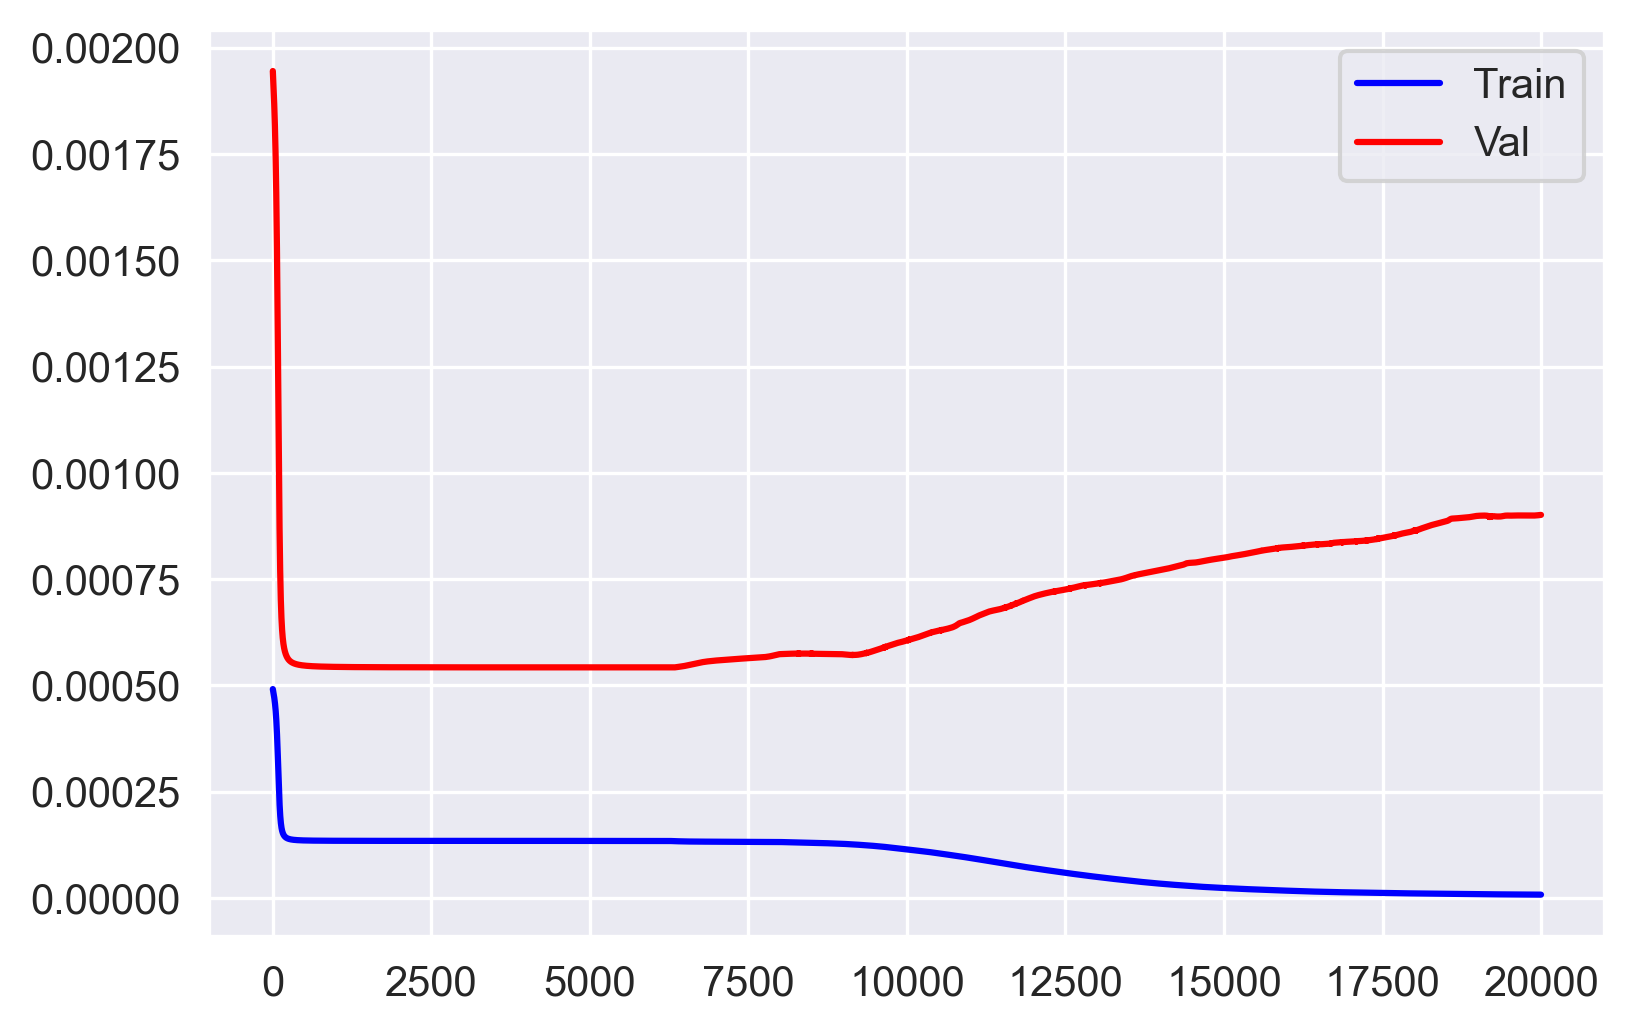

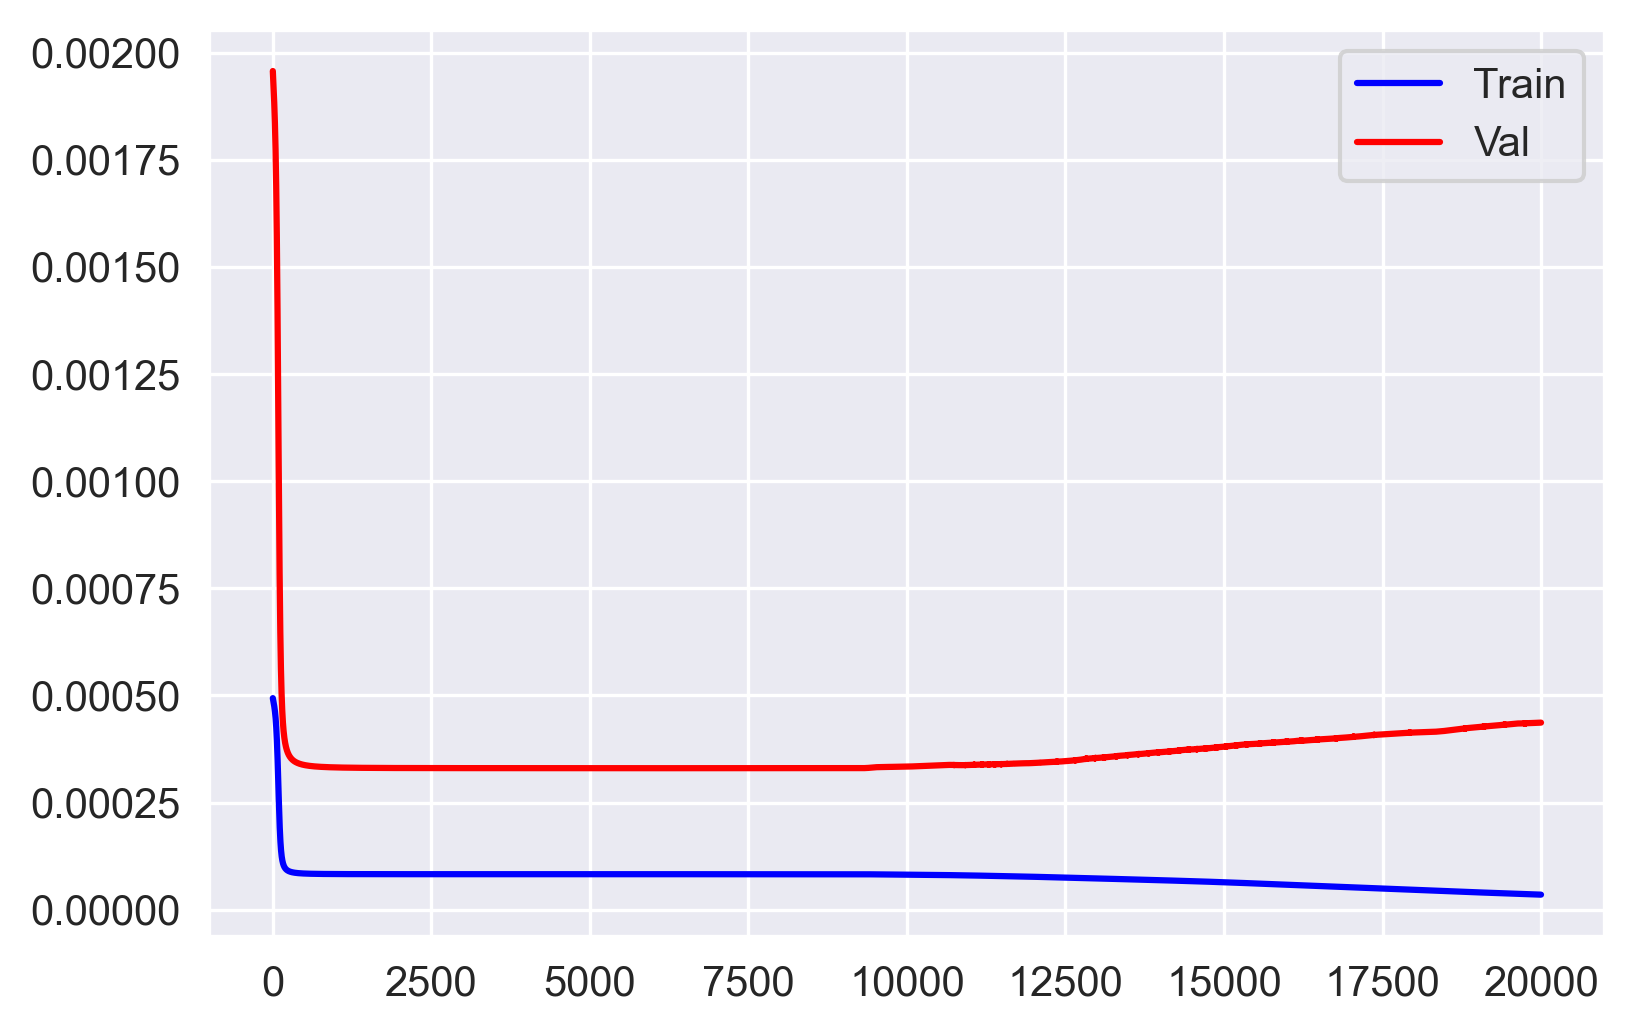

In [56]:
import torch.optim as optim
model_a = MLP(n_output = 21, n_hidden = 100, n_layers = 3, activation=nn.Tanh())
model_b = MLP(n_output = 40, n_hidden = 100, n_layers = 3, activation=nn.Tanh())

criterion = nn.MSELoss(reduction = 'mean')
opt = optim.Adam

loss_A = train(model_a, X_train_a, y_train_a, X_test_a, y_test_a, criterion, opt, epochs=20000, eta=1e-4, name = 'A')
loss_B = train(model_b, X_train_b, y_train_b, X_test_b, y_test_b, criterion, opt, epochs=20000, eta=1e-4, name = 'B')

In [54]:
chkpt = torch.load(os.getcwd()+'MLPA.pth.tar')
model_a.load_state_dict(chkpt['state_dict'])

<All keys matched successfully>

In [143]:
from sklearn.metrics import hamming_loss
y_pred = model_a(torch.tensor(X_test_a).to(device))
thr = nn.Threshold(0.1,0)
y_pred = thr(y_pred)
y_pred[y_pred>0] = 1 
hamming_loss(y_test_a, y_pred.detach().cpu())

0.1870748299319728

In [149]:
get_allele_name(y_test_a[0], y_test_b[0])

(array(['A11', 'A31'], dtype='<U7'), array(['B14', 'B27'], dtype='<U7'))

In [150]:
y_test_a.shape

torch.Size([126, 21])

In [132]:
y_pred = model_a(torch.tensor(X_train_a).to(device))
thr = nn.Threshold(0.1,0)
y_pred = thr(y_pred)
for i in range(5):
    print(f'\n{y_train_a[i]}\n{y_pred[i]}')


tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
tensor([0.0000, 0.9220, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.8596, 0.0000, 0.1219, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward>)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.9833, 0.0000, 0.9802, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward>)

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9951, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      

#### Binary Logistic

In [221]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
clf_a = {}
clf_b = {}
for a in tqdm(range(21)):
    #binary clf
    clf = LogisticRegressionCV(max_iter = 1000)
    clf.fit(X_train_a, y_train_a[:,a])
    clf_a[hla_a[a]] = clf
    y_pred = clf_a[hla_a[a]].predict(X_test_a)
    print(f'Accuracy for {hla_a[a]}: {accuracy_score(y_test_a[:,a], y_pred)}')
for b in tqdm(range(40)):
    clf = LogisticRegressionCV(max_iter = 1000)
    clf.fit(X_train_b, y_train_b[:,b])
    clf_b[hla_b[b]] = clf
    y_pred = clf_b[hla_b[b]].predict(X_test_b)
    print(f'Accuracy for {hla_b[b]}: {accuracy_score(y_test_b[:,b], y_pred)}')

  0%|          | 0/21 [00:00<?, ?it/s]

Accuracy for A01: 0.7063492063492064
Accuracy for A02: 0.5317460317460317
Accuracy for A03: 0.8253968253968254
Accuracy for A11: 0.8650793650793651
Accuracy for A23: 0.9761904761904762
Accuracy for A24: 0.7857142857142857
Accuracy for A25: 0.9603174603174603
Accuracy for A26: 0.9206349206349206
Accuracy for A28: 1.0
Accuracy for A29: 0.9444444444444444
Accuracy for A30: 0.9444444444444444
Accuracy for A31: 0.8968253968253969
Accuracy for A32: 0.9047619047619048
Accuracy for A33: 0.9761904761904762
Accuracy for A34: 0.9841269841269841
Accuracy for A36: 1.0
Accuracy for A66: 0.9920634920634921
Accuracy for A68: 0.9285714285714286
Accuracy for A69: 1.0
Accuracy for A74: 1.0
Accuracy for A80: 1.0


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy for B05: 1.0
Accuracy for B07: 0.753968253968254
Accuracy for B08: 0.7857142857142857
Accuracy for B13: 0.9603174603174603
Accuracy for B14: 0.9047619047619048
Accuracy for B15: 0.9444444444444444
Accuracy for B17: 1.0
Accuracy for B18: 0.8968253968253969
Accuracy for B22: 1.0
Accuracy for B27: 0.9047619047619048
Accuracy for B35: 0.8174603174603174
Accuracy for B37: 0.9841269841269841
Accuracy for B38: 0.9365079365079365
Accuracy for B39: 0.9682539682539683
Accuracy for B40: 1.0
Accuracy for B41: 0.9841269841269841
Accuracy for B42: 1.0
Accuracy for B44: 0.7619047619047619
Accuracy for B45: 0.9920634920634921
Accuracy for B47: 1.0
Accuracy for B48: 1.0
Accuracy for B49: 0.9523809523809523
Accuracy for B50: 0.9841269841269841
Accuracy for B51: 0.8492063492063492
Accuracy for B52: 0.9841269841269841
Accuracy for B53: 0.9920634920634921
Accuracy for B54: 1.0
Accuracy for B55: 0.9523809523809523
Accuracy for B56: 0.9841269841269841
Accuracy for B57: 0.9682539682539683
Accuracy fo

#### Retry but with thresholded matrix

In [273]:
occurenceFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/occurence_freq.csv', header=0)
sumFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/sum_freq.csv', header=0)
normed_sumFREQ = pd.read_csv('../training_data_new/emerson_raw/batch1/normed_sumfreq.csv', header=0)


tcrbv_cols = normed_sumFREQ.columns[normed_sumFREQ.columns.str.startswith('TCRBV')]
hla_cols = normed_sumFREQ.columns[normed_sumFREQ.columns.str.startswith('hla')]
#not Thresholding
#XMAT = (normed_sumFREQ[tcrbv_cols])# >= 0.05) + 0
#X = XMAT.values

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X,y_a, train_size=2/3)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,y_b, train_size=2/3)

In [242]:
for a in tqdm(range(21)):
    print(f'HLA:{hla_a[a]}, {len(y_a[:,a][y_a[:,a] == 1])}')

  0%|          | 0/21 [00:00<?, ?it/s]

HLA:A01, 186
HLA:A02, 294
HLA:A03, 153
HLA:A11, 61
HLA:A23, 27
HLA:A24, 129
HLA:A25, 26
HLA:A26, 50
HLA:A28, 2
HLA:A29, 50
HLA:A30, 35
HLA:A31, 33
HLA:A32, 39
HLA:A33, 22
HLA:A34, 7
HLA:A36, 1
HLA:A66, 4
HLA:A68, 47
HLA:A69, 1
HLA:A74, 1
HLA:A80, 2


In [243]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
clf_threshold_a = {}
clf_threshold_b = {}
for a in tqdm(range(21)):
    #binary clf
    if len(y_a[:,a][y_a[:,a] == 1]) < 20 : continue
    clf = LogisticRegressionCV(max_iter = 1000)
    clf.fit(X_train_a, y_train_a[:,a])
    clf_threshold_a[hla_a[a]] = clf
    y_pred = clf_threshold_a[hla_a[a]].predict(X_test_a)
    print(f'ROC_AUC for {hla_a[a]}: {roc_auc_score(y_test_a[:,a], y_pred)}')
for b in tqdm(range(40)):
    if len(y_b[:,b][y_b[:,b] == 1]) < 20 : continue
    clf = LogisticRegressionCV(max_iter = 1000)
    clf.fit(X_train_b, y_train_b[:,b])
    clf_threshold_b[hla_b[b]] = clf
    y_pred = clf_threshold_b[hla_b[b]].predict(X_test_b)
    print(f'ROC_AUC for {hla_b[b]}: {roc_auc_score(y_test_b[:,b], y_pred)}')

  0%|          | 0/21 [00:00<?, ?it/s]

Accuracy for A01: 0.6746411483253588
Accuracy for A02: 0.49760765550239233
Accuracy for A03: 0.7559808612440191
Accuracy for A11: 0.8995215311004785
Accuracy for A23: 0.9665071770334929
Accuracy for A24: 0.7416267942583732
Accuracy for A25: 0.9569377990430622
Accuracy for A26: 0.9186602870813397
Accuracy for A29: 0.8851674641148325
Accuracy for A30: 0.9521531100478469
Accuracy for A31: 0.9760765550239234
Accuracy for A32: 0.9521531100478469
Accuracy for A33: 0.9617224880382775
Accuracy for A68: 0.8851674641148325


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy for B07: 0.8086124401913876
Accuracy for B08: 0.7559808612440191
Accuracy for B13: 0.9521531100478469
Accuracy for B14: 0.9186602870813397
Accuracy for B15: 0.9425837320574163
Accuracy for B18: 0.8995215311004785
Accuracy for B27: 0.9234449760765551
Accuracy for B35: 0.8086124401913876
Accuracy for B38: 0.9330143540669856
Accuracy for B39: 0.9617224880382775
Accuracy for B40: 0.9712918660287081
Accuracy for B44: 0.7607655502392344
Accuracy for B51: 0.861244019138756
Accuracy for B57: 0.9282296650717703
Accuracy for B60: 0.9330143540669856
Accuracy for B62: 0.9186602870813397


In [254]:
not any(y_pred!=0)

True

In [265]:
clf_xgb_a['A01']

XGBClassifier(alpha=0.05, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eta=0.6,
              eval_metric='logloss', gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='', lambda=1,
              learning_rate=0.600000024, max_delta_step=10, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0.0500000007, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [275]:
import xgboost as xgb
#xgb.XGBClassifier?
clf_xgb_a = {}
clf_xgb_b = {}
params = {'booster':'gbtree',
          'eta':0.6,
          'max_depth' : 7,
          'min_child_weight': 1,
          'colsample_bytree': 0.3,
          'lambda':1,
          'alpha':0.05,
          'gamma': 0.1,
          'max_delta_step':10,
          'verbosity':0,
          'tree_method':'exact',
          'objective':'binary:logistic',
          'eval_metric':'logloss'}

for a in tqdm(range(21)):
    #binary clf
    if len(y_a[:,a][y_a[:,a] == 1]) < 20 : continue
    clf = xgb.XGBClassifier(tree_method='gpu_hist')
    _ = clf.set_params(**params)
    clf.fit(X_train_a, y_train_a[:,a])
    clf_xgb_a[hla_a[a]] = clf
    y_pred = clf_xgb_a[hla_a[a]].predict(X_test_a)
    if not any(y_pred!=0): print(f'Predicted all 0 for {hla_a[a]}')
    print(f'Test ROC AUC for {hla_a[a]}:\t{roc_auc_score(y_test_a[:,a], y_pred):.2%}'\
          f'\n\tTest F-1 score:\t{f1_score(y_test_a[:,a], y_pred):.2%}')
    
for b in tqdm(range(40)):
    if len(y_b[:,b][y_b[:,b] == 1]) < 20 : continue
    clf = xgb.XGBClassifier(tree_method='gpu_hist')
    _ = clf.set_params(**params)
    clf.fit(X_train_b, y_train_b[:,b])
    clf_xgb_b[hla_b[b]] = clf
    y_pred = clf_xgb_b[hla_b[b]].predict(X_test_b)
    if not any(y_pred!=0): print(f'Predicted all 0 for {hla_b[b]}')
    print(f'Test ROC AUC for {hla_b[b]} :\t{roc_auc_score(y_test_b[:,b], y_pred):.2%}'\
          f'\nTest F-1 score:\t{f1_score(y_test_b[:,b], y_pred):.2%}')


#print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test_a, clf.predict(X_test_a))*100))

  0%|          | 0/21 [00:00<?, ?it/s]

Test ROC AUC for A01:	46.89%
	Test F-1 score:	12.82%
Test ROC AUC for A02:	54.71%
	Test F-1 score:	51.78%
Test ROC AUC for A03:	53.48%
	Test F-1 score:	18.92%
Predicted all 0 for A11
Test ROC AUC for A11:	50.00%
	Test F-1 score:	0.00%
Test ROC AUC for A23:	49.75%
	Test F-1 score:	0.00%
Test ROC AUC for A24:	49.12%
	Test F-1 score:	7.69%
Predicted all 0 for A25
Test ROC AUC for A25:	50.00%
	Test F-1 score:	0.00%
Test ROC AUC for A26:	52.52%
	Test F-1 score:	10.00%
Test ROC AUC for A29:	49.50%
	Test F-1 score:	0.00%
Predicted all 0 for A30
Test ROC AUC for A30:	50.00%
	Test F-1 score:	0.00%
Test ROC AUC for A31:	49.75%
	Test F-1 score:	0.00%
Predicted all 0 for A32
Test ROC AUC for A32:	50.00%
	Test F-1 score:	0.00%
Test ROC AUC for A33:	49.75%
	Test F-1 score:	0.00%
Test ROC AUC for A68:	49.74%
	Test F-1 score:	0.00%


  0%|          | 0/40 [00:00<?, ?it/s]

Test ROC AUC for B07 :	46.60%
Test F-1 score:	8.33%
Test ROC AUC for B08 :	52.27%
Test F-1 score:	17.39%
Predicted all 0 for B13
Test ROC AUC for B13 :	50.00%
Test F-1 score:	0.00%
Predicted all 0 for B14
Test ROC AUC for B14 :	50.00%
Test F-1 score:	0.00%
Predicted all 0 for B15
Test ROC AUC for B15 :	50.00%
Test F-1 score:	0.00%
Predicted all 0 for B18
Test ROC AUC for B18 :	50.00%
Test F-1 score:	0.00%
Predicted all 0 for B27
Test ROC AUC for B27 :	50.00%
Test F-1 score:	0.00%
Test ROC AUC for B35 :	51.89%
Test F-1 score:	10.26%
Test ROC AUC for B38 :	49.75%
Test F-1 score:	0.00%
Predicted all 0 for B39
Test ROC AUC for B39 :	50.00%
Test F-1 score:	0.00%
Predicted all 0 for B40
Test ROC AUC for B40 :	50.00%
Test F-1 score:	0.00%
Test ROC AUC for B44 :	51.43%
Test F-1 score:	19.75%
Test ROC AUC for B51 :	49.71%
Test F-1 score:	0.00%
Test ROC AUC for B57 :	49.75%
Test F-1 score:	0.00%
Predicted all 0 for B60
Test ROC AUC for B60 :	50.00%
Test F-1 score:	0.00%
Predicted all 0 for B62
T

In [8]:
from sklearn.model_selection import train_test_split
from src.preprocessing import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

occurenceFREQ = pd.read_csv('./occurence_freq.csv', header=0)
sumFREQ = pd.read_csv('./sum_freq.csv', header=0)
normed_sumFREQ = pd.read_csv('./normed_sumfreq.csv', header=0)


#getting the columns and labels once either of those CSV are read : Here is with normed_sumfreq.csv
tcrbv_cols = normed_sumFREQ.columns[normed_sumFREQ.columns.str.startswith('TCRBV')]
hla_cols = normed_sumFREQ.columns[normed_sumFREQ.columns.str.startswith('hla')]
X = normed_sumFREQ[tcrbv_cols].values

# get_all_label is from src.preprocessing.py 
y_a, y_b = get_all_label(normed_sumFREQ[hla_cols].values[:,0],
                         normed_sumFREQ[hla_cols].values[:,1],
                         normed_sumFREQ[hla_cols].values[:,2],
                         normed_sumFREQ[hla_cols].values[:,3])

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X,y_a, train_size=0.8)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,y_b, train_size=0.8)

#loading some dicts
hla_a = load_pkl('./hla_a.pkl')
hla_b = load_pkl('./hla_b.pkl')
#
clf_threshold_a = {}
clf_threshold_b = {}

for a in tqdm(range(21)):
    #binary clf
    if len(y_a[:,a][y_a[:,a] == 1]) < 20 : continue
    clf = LogisticRegressionCV(max_iter = 1000)
    clf.fit(X_train_a, y_train_a[:,a])
    clf_threshold_a[hla_a[a]] = clf
    y_pred = clf_threshold_a[hla_a[a]].predict(X_test_a)
    print(f'ROC_AUC for {hla_a[a]}: {roc_auc_score(y_test_a[:,a], y_pred)}')
for b in tqdm(range(40)):
    if len(y_b[:,b][y_b[:,b] == 1]) < 20 : continue
    clf = LogisticRegressionCV(max_iter = 1000)
    clf.fit(X_train_b, y_train_b[:,b])
    clf_threshold_b[hla_b[b]] = clf
    y_pred = clf_threshold_b[hla_b[b]].predict(X_test_b)
    print(f'ROC_AUC for {hla_b[b]}: {roc_auc_score(y_test_b[:,b], y_pred)}')

  0%|          | 0/21 [00:00<?, ?it/s]

ROC_AUC for A01: 0.5
ROC_AUC for A02: 0.4652777777777778
ROC_AUC for A03: 0.5
ROC_AUC for A11: 0.5
ROC_AUC for A23: 0.5
ROC_AUC for A24: 0.4947916666666667
ROC_AUC for A25: 0.5
ROC_AUC for A26: 0.5
ROC_AUC for A29: 0.5
ROC_AUC for A30: 0.5
ROC_AUC for A31: 0.5
ROC_AUC for A32: 0.5
ROC_AUC for A33: 0.5
ROC_AUC for A68: 0.5


  0%|          | 0/40 [00:00<?, ?it/s]

ROC_AUC for B07: 0.5
ROC_AUC for B08: 0.5
ROC_AUC for B13: 0.5
ROC_AUC for B14: 0.5
ROC_AUC for B15: 0.5
ROC_AUC for B18: 0.5
ROC_AUC for B27: 0.5
ROC_AUC for B35: 0.5
ROC_AUC for B38: 0.5
ROC_AUC for B39: 0.5
ROC_AUC for B40: 0.5
ROC_AUC for B44: 0.5
ROC_AUC for B51: 0.5
ROC_AUC for B57: 0.5
ROC_AUC for B60: 0.5
ROC_AUC for B62: 0.5
